## Run KL analysis for intergenic region, footprinting region, and DHS sites

In [12]:
import sys
import pandas as pd
import torch
import pyro
from tqdm import tqdm


sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL')

import raklette_updated


## load file

In [2]:
KL_data_dir = "/home/djl34/lab_pd/kl/data/"
scratch_dir = "/n/scratch3/users/d/djl34/"

In [3]:
sfs = pd.read_csv(KL_data_dir + "neutral_SFS_5bins.tsv", sep = "\t")

bin_columns = []

for i in range(5):
    bin_columns.append(str(i) + "_bin")

neutral_sfs = torch.tensor(sfs[bin_columns].values)

mu_ref = torch.tensor(sfs["mu"].values)

In [4]:
df = pd.read_csv(scratch_dir + "KL_input/intergenic_footprinting/22.tsv", sep = "\t")

In [5]:
# initially, filter out mu values that are not in the list
df = df[df["mu"].isin(list(sfs["mu"].unique()))]
res = dict(zip(sfs["mu"], sfs.index))
df["mu_index"] = [res[x] for x in df["mu"]]

In [6]:
mu_vals = torch.tensor(df["mu_index"].values)
gene_ids = torch.tensor(df["type"].values - 1)
sample_sfs = torch.tensor(df["Freq_bin"].values)

In [7]:
covariates = torch.tensor([1]*len(mu_vals))
covariates = covariates.unsqueeze(0).transpose(0,1).type(torch.FloatTensor)

## inference portion

In [8]:
#define variables
#define neut_sfs_full, mu_vals, gene_ids, covariates
n_covs = covariates.shape[-1]          # number of covariates included
n_genes = len(torch.unique(gene_ids))  # number of genes

n_covs = 0

# n_covs = 1
# n_genes = 3
n_bins = len(neutral_sfs[1]) - 1

In [9]:
#define model and guide
KL = raklette_updated.raklette(neutral_sfs, n_bins, mu_ref, n_covs, n_genes)
model = KL.model
guide = pyro.infer.autoguide.AutoNormal(model)

In [10]:
#run inference
pyro.clear_param_store()
# run SVI
adam = pyro.optim.Adam({"lr":0.005})
elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
svi = pyro.infer.SVI(model, guide, adam, elbo)
losses = []

In [13]:
n_steps = 1000

for step in tqdm(range(n_steps)): # tqdm is just a progress bar thing 
    loss = svi.step(mu_vals, gene_ids, covariates, sample_sfs)
    print(loss)
    losses.append(loss)

  0%|                                                                                                                      | 1/1000 [00:05<1:38:42,  5.93s/it]

13443779.175119542


  0%|▏                                                                                                                     | 2/1000 [00:09<1:11:32,  4.30s/it]

13655261.282229315


  0%|▎                                                                                                                     | 3/1000 [00:12<1:02:45,  3.78s/it]

13438918.132160187


  0%|▍                                                                                                                       | 4/1000 [00:15<58:22,  3.52s/it]

13190992.77591341


  0%|▌                                                                                                                       | 5/1000 [00:18<55:58,  3.38s/it]

13404924.42768617


  1%|▋                                                                                                                       | 6/1000 [00:21<54:19,  3.28s/it]

13604929.965206178


  1%|▊                                                                                                                       | 7/1000 [00:24<53:27,  3.23s/it]

13315710.80159913


  1%|▊                                                                                                                     | 7/1000 [00:25<1:00:24,  3.65s/it]


KeyboardInterrupt: 

In [49]:
# for epoch in range(num_epochs):
#     losses = []

#     # Take a gradient step for each mini-batch in the dataset
#     for x, y in dataloader:
#         if y is not None:
#             y = y.type_as(x)
#         loss = svi.step(x, y)
#         losses.append(loss)

#     # Tell the scheduler we've done one epoch.
#     scheduler.step()

#     print("[Epoch %02d]  Loss: %.5f" % (epoch, np.mean(losses)))

# print("Finished training!")

3647420

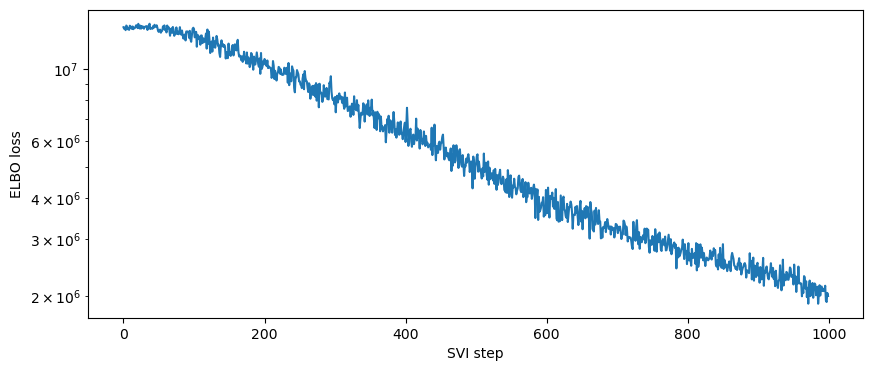

In [25]:
fig, ax = plot_losses(losses)

## post inference portion (same as raklette_daniel.py)

In [29]:
np.mean(result["KL_fw_post"], axis = 0)

array([7.76460804, 0.37161576, 7.52047177])

In [30]:
np.mean(result["KL_rv_post"], axis = 0)

array([3.98525769, 0.52109279, 3.9743914 ])